# Lesson 6: pets revisited

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

In [2]:
bs = 32

In [3]:
path = untar_data(URLs.PETS)/'images'

In [4]:
# Import the module.
from fastai.callbacks.loss_metrics import *
import monascastatsd as mstatsd

# Create the connection
conn = mstatsd.Connection(host='openhpc-login-0', port=8125)

# Create the client with optional dimensions
client = mstatsd.Client(connection=conn, dimensions={'env': 'fastai'})

# Create a gauge called fastai
gauge = client.get_gauge('fastai', dimensions={'env': 'fastai'})

class PostMetrics(LearnerCallback):

    def __init__(self):
        self.stop = False

    def on_batch_end(self, last_loss, **kwargs:Any)->None:
        if self.stop: return True #to skip validation after stopping during training
        # Record a gauge 50% of the time.
        gauge.send('trn_loss', float(last_loss), sample_rate=1.0)
        
    def on_epoch_end(self, last_loss, epoch, smooth_loss, last_metrics, **kwargs:Any):
        val_loss, error_rate = last_metrics
        gauge.send('val_loss', float(val_loss), sample_rate=1.0)
        gauge.send('error_rate', float(error_rate), sample_rate=1.0)        
        gauge.send('smooth_loss', float(smooth_loss), sample_rate=1.0)
        gauge.send('trn_loss', float(last_loss), sample_rate=1.0)
        gauge.send('epoch', int(epoch), sample_rate=1.0)        

## Data augmentation

In [5]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

In [6]:
doc(get_transforms)

In [7]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)

In [8]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [9]:
data = get_data(224, bs, 'zeros')

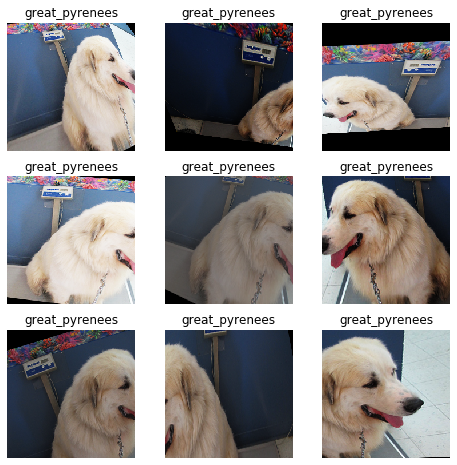

In [10]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [11]:
data = get_data(224,bs)

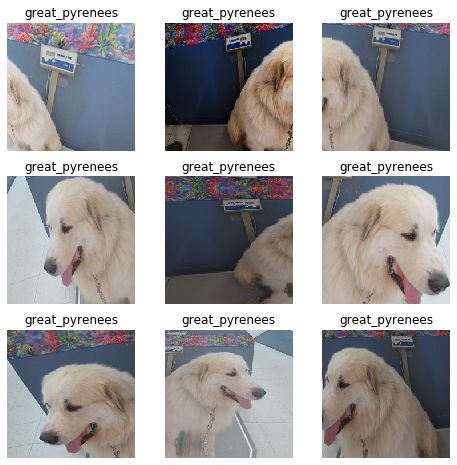

In [12]:
plot_multi(_plot, 3, 3, figsize=(8,8))

## Train a model

In [13]:
gc.collect()
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True, callbacks=[PostMetrics()])

In [14]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,2.490115,1.402805,0.235453,00:22
1,1.289928,0.334222,0.095399,00:20
2,0.900708,0.255729,0.066306,00:20


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time


In [ ]:
data = get_data(352,bs)
learn.data = data

In [ ]:
learn.fit_one_cycle(1, max_lr=slice(1e-6,1e-4))

In [ ]:
learn.save('352')

## Convolution kernel

In [ ]:
data = get_data(352,16)

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True, callbacks=[PostMetrics()]).load('352')

In [ ]:
idx=40
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [ ]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6

In [ ]:
k

In [ ]:
k.shape

In [ ]:
t = data.valid_ds[idx][0].data; t.shape

In [ ]:
t[None].shape

In [ ]:
edge = F.conv2d(t[None], k)

In [ ]:
show_image(edge[0], figsize=(5,5));

In [ ]:
data.c

In [ ]:
learn.model

In [ ]:
print(learn.summary())

## Heatmap

In [ ]:
m = learn.model.eval();

In [ ]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [ ]:
from fastai.callbacks.hooks import *

In [ ]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [ ]:
hook_a,hook_g = hooked_backward()

In [ ]:
acts  = hook_a.stored[0].cpu()
acts.shape

In [ ]:
avg_acts = acts.mean(0)
avg_acts.shape

In [ ]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

In [ ]:
show_heatmap(avg_acts)

## Grad-CAM

Paper: [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

In [ ]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

In [ ]:
mult = (acts*grad_chan[...,None,None]).mean(0)

In [ ]:
show_heatmap(mult)

In [ ]:
fn = path/'../other/bulldog_maine.jpg' #Replace with your own image

In [ ]:
fn = 'tank.jpg'

In [ ]:
!curl https://nationalinterest.org/sites/default/files/styles/desktop__1486_x_614/public/main_images/tankbiathlon2016final-28.jpg?itok=UM1HBUl1 > {fn}

In [ ]:
x = open_image(fn); x

In [ ]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [ ]:
hook_a,hook_g = hooked_backward()

In [ ]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

In [ ]:
show_heatmap(mult)

In [ ]:
data.classes[0]

In [ ]:
hook_a,hook_g = hooked_backward(0)

In [ ]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

In [ ]:
show_heatmap(mult)

## fin